In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns


import requests
from bs4 import BeautifulSoup
import os
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from tqdm import tqdm
import time

from tensorflow.keras.models import load_model

### Llamamos los fits estandarizados para la comprobacion

In [2]:
#archivos=['DataDESI_36.fits', 'DataDESI_72.fits', 'DataDESI_108.fits', 'DataDESI_144.fits', 'DataDESI_180.fits', 'DataDESI_216.fits'
 #, 'DataDESI_252.fits', 'DataDESI_288.fits', 'DataDESI_324.fits', 'DataDESI_360.fits', 'DataDESI_379.fits']
#archivos=['DataDESI_36.fits', 'DataDESI_72.fits']
archivos=['DataDESI_36.fits']

#Generamos las listas con los datos:
Spectra_set= None #Este tensor contiene los elementos de flujo completo R+Z+B
y=np.array([]) #Esta lsita contiene las etiquetas para el ejercicio de clasificacion
z=np.array([]) #Esta matriz contiene los corrimientos z para el ejercicio de regresion

for h in range(len(archivos)):
    espc = fits.open(archivos[h]) #open file
    len_espc= len(espc[2].data)
    
    #leemos la informacion
    Bflux=espc[2].data
    Zflux=espc[4].data
    Rflux=espc[3].data
    
    spectra=np.hstack((Bflux, Zflux, Rflux)) #Contiene la cadena completa de flujo B+Z+R para cada espectro
    spectra=spectra.reshape(spectra.shape[0], spectra.shape[1], 1)
    
    if Spectra_set is None:
        Spectra_set = spectra
    else:
        Spectra_set = np.concatenate((Spectra_set, spectra), axis=0)
    
    y=np.append(y, Table.read(espc, hdu=1)['SPECTYPE'].data)
    
    z=np.append(z, Table.read(espc, hdu=1)['Z'].data)
    z=z.reshape(-1,1)

#Tenemos el tensor Spectra_set que contiene todos los flujos de los .fits seleccionados
#y es una lista con las etiquetas de dichos espectros
#z una matriz con los valores de corrimiento de cada espectro.


### Cargamos el modelo de regresion y comprobamos

1980/1980 [==============================] - 68s 34ms/step


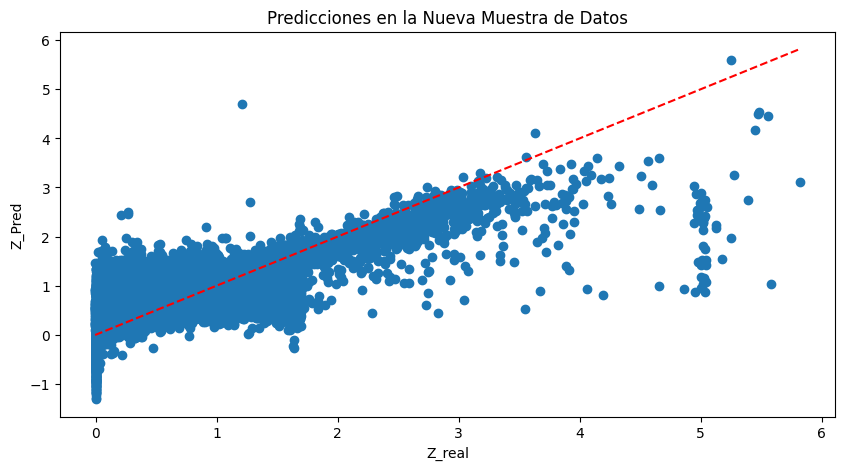

In [16]:
# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_regresion_1.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)

# Visualizar las predicciones en la nueva muestra de datos
plt.figure(figsize=(10, 5))
plt.scatter(z, predictions_new)
x_line = np.linspace(min(z), max(z), 100)  # Crear puntos para la línea
y_line = x_line  # Pendiente 1
plt.plot(x_line, y_line, color='red', linestyle='--', label="Pendiente 1")
plt.title("Predicciones en la Nueva Muestra de Datos")
plt.xlabel("Z_real")
plt.ylabel("Z_Pred")
plt.show()

### Cargamos el modelo de clasifiacion y comprobamos

1980/1980 [==============================] - 72s 36ms/step


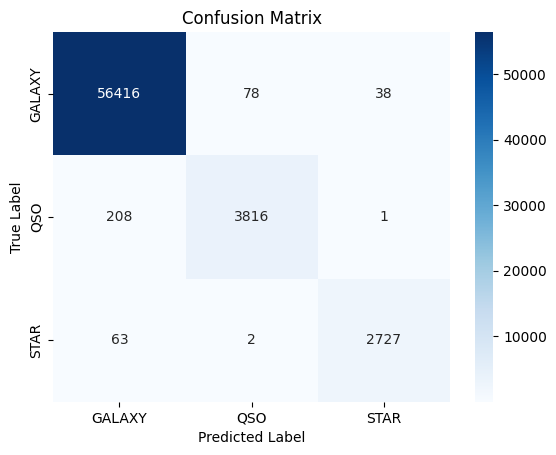

In [8]:
y = np.array(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y_categorical = to_categorical(y)


# Cargar el modelo desde el archivo HDF5
loaded_model = load_model("mi_modelo_clasifiacion_1.h5")

# Hacer predicciones sobre la nueva muestra de datos
predictions_new = loaded_model.predict(Spectra_set)    #GALAXY=0, QSO=1, STAR=2

# Obtener las etiquetas reales y predichas
true_labels = np.argmax(y_categorical, axis=1)
predicted_labels = np.argmax(predictions_new, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión con seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
